# 1. English names generation

Language model implemented with RNN

In [1]:
%pip install gdown

In [2]:
%%bash
gdown 1QDbtPWGQypYxiS4pC_hHBBtbRHk9gEtr
unzip name_dataset.zip

Archive:  name_dataset.zip
   creating: name_dataset/
   creating: name_dataset/data/
  inflating: name_dataset/data/MY.csv  
  inflating: name_dataset/data/CR.csv  
  inflating: name_dataset/data/AZ.csv  
  inflating: name_dataset/data/TM.csv  
  inflating: name_dataset/data/AL.csv  
  inflating: name_dataset/data/BW.csv  
  inflating: name_dataset/data/MX.csv  
  inflating: name_dataset/data/MO.csv  
  inflating: name_dataset/data/NA.csv  
  inflating: name_dataset/data/TN.csv  
  inflating: name_dataset/data/AO.csv  
  inflating: name_dataset/data/BG.csv  
  inflating: name_dataset/data/UY.csv  
  inflating: name_dataset/data/ZA.csv  
  inflating: name_dataset/data/BF.csv  
  inflating: name_dataset/data/NG.csv  
  inflating: name_dataset/data/BD.csv  
  inflating: name_dataset/data/BR.csv  
  inflating: name_dataset/data/BE.csv  
  inflating: name_dataset/data/CA.csv  
  inflating: name_dataset/data/LY.csv  
  inflating: name_dataset/data/IR.csv  
  inflating: name_dataset/data/IE.

Downloading...
From (original): https://drive.google.com/uc?id=1QDbtPWGQypYxiS4pC_hHBBtbRHk9gEtr
From (redirected): https://drive.google.com/uc?id=1QDbtPWGQypYxiS4pC_hHBBtbRHk9gEtr&confirm=t&uuid=c9348c5b-3a28-4caa-9f30-894e4e7952ca
To: /content/name_dataset.zip
100%|██████████| 3.50G/3.50G [00:40<00:00, 85.7MB/s]


In [7]:
import pandas as pd
import numpy as np

df = pd.read_csv("name_dataset/data/GB.csv", header=None, dtype=pd.StringDtype()).dropna()
df

,0,1,2,3
0,Luxeena,Binoy,F,GB
1,Lisa,Allen,F,GB
3,Luke,Murphy,M,GB
4,Adrian,Heacock,M,GB
5,Elvinas,Palubinskas,M,GB
...,...,...,...,...
11519223,Michael,Mccabe,M,GB
11519224,Niamh,Briffa,F,GB
11519225,Henni,Amara,F,GB
11519226,Tiffany,Lee,F,GB


In [8]:
names_data = np.unique(df.loc[df[0].str.fullmatch("^[a-zA-Z]+$"), 0].to_numpy())
names_data

array(['Aab', 'Aaba', 'Aaban', ..., 'Zzwen', 'Zzxjorgrxzz', 'Zzyyx'],
      dtype=object)

In [9]:
len(names_data)

342757

In [10]:
np.random.choice(names_data, 10)

array(['Paulune', 'Mujahod', 'Ermalyn', 'Kaifi', 'Rhayra', 'Npmmano',
       'Niththi', 'Blantina', 'Rachelegeorgina', 'Saahd'], dtype=object)

## Dataset

**Processing pipeline:**

chars (tokens) $\to$ indices $\to$ embeddings $\to$ RNN output, hidden $\to$ next char logits

In [11]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import build_vocab_from_iterator
from collections import Counter


plt.rcParams.update({'font.size': 14})
sns.set_style('whitegrid')


class NamesDataset(Dataset):
    def __init__(self, names):
        self.names = names
        self.specials = ['<pad>', '<bos>', '<eos>']
        self.vocab = build_vocab_from_iterator(names, specials=self.specials)
        print(len(self.vocab))
        self.itos = self.vocab.get_itos()
        self.pad_index = self.vocab['<pad>']
        self.bos_index = self.vocab['<bos>']
        self.eos_index = self.vocab['<eos>']
        self.max_len = max(len(name) for name in names) + 2

    def __len__(self):
        return len(self.names)

    def str_to_idx(self, chars):
        return [self.vocab[char] for char in chars]

    def idx_to_str(self, idx):
        return [self.itos[index] for index in idx]

    def encode(self, chars):
        chars = ['<bos>'] + list(chars) + ['<eos>']
        return self.str_to_idx(chars)

    def decode(self, idx):
        chars = self.idx_to_str(idx)
        return ''.join(char for char in chars if char not in self.specials)

    def __getitem__(self, item):
        encoded = self.encode(self.names[item])
        padded = torch.full((self.max_len, ), self.pad_index, dtype=torch.int64)
        padded[:len(encoded)] = torch.tensor(encoded)
        return padded, len(encoded)

In [12]:
dataset = NamesDataset(names_data)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

55


In [14]:
dataset.itos

['<pad>',
 '<bos>',
 '<eos>',
 'a',
 'e',
 'i',
 'n',
 'r',
 'o',
 'l',
 'h',
 's',
 'u',
 't',
 'y',
 'd',
 'm',
 'k',
 'S',
 'g',
 'c',
 'b',
 'M',
 'A',
 'z',
 'v',
 'j',
 'p',
 'K',
 'C',
 'T',
 'B',
 'D',
 'R',
 'f',
 'J',
 'w',
 'N',
 'L',
 'P',
 'H',
 'G',
 'E',
 'F',
 'I',
 'V',
 'O',
 'Y',
 'Z',
 'x',
 'W',
 'q',
 'U',
 'X',
 'Q']

In [ ]:
for names, _ in dataloader:
    break

# 0 - <pad>
# 1 - <bos>
# 2 - <eos>
names[:4]

## Generator model

Embedding + RNN + Linear head

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [16]:
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.distributions.categorical import Categorical


class Generator(nn.Module):
    def __init__(self, dataset, embed_dim=32, hidden_dim=32, max_len=None):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=len(dataset.vocab), embedding_dim=embed_dim,
                                      padding_idx=dataset.pad_index)
        self.rnn = nn.RNN(input_size=embed_dim, hidden_size=hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, len(dataset.vocab))
        self.dataset = dataset
        self.max_len = dataset.max_len if max_len is None else max_len

    def forward(self, tokens, lengths):
        '''
        B - batch size
        L - sequence length
        E - embedding dim
        H - hidden dim
        V - vocab size
        '''
        # tokens: (B, L)
        embeds = self.embedding(tokens)
        # embeds: (B, L, E) in padded form
        packed_embeds = pack_padded_sequence(embeds, lengths, batch_first=True, enforce_sorted=False)
        outputs, hidden = self.rnn(packed_embeds)
        # output: (B, L, H), hidden: (B, H) in packed form
        outputs, lengths = pad_packed_sequence(outputs, batch_first=True)
        logits = self.linear(outputs)
        # logits: (B, L, V)
        return logits

    @torch.no_grad()
    def inference(self, prefix=''):
        # encode prefix
        tokens = self.dataset.encode(prefix)[:-1]
        tokens = torch.tensor(tokens).unsqueeze(0).to(device)

        # generate hidden for prefix
        embeds = self.embedding(tokens)
        output, hidden = self.rnn(embeds)
        logits = self.linear(output)

        # sample new token from logits
        new_tokens = Categorical(logits=logits[:, -1:]).sample()
        tokens = torch.cat([tokens, new_tokens], dim=1)

        # 2 stopping conditions: reaching max len or getting <eos> token
        while tokens.shape[1] < self.max_len:
            if new_tokens.item() == self.dataset.eos_index:
                break

            # process newly obtained token
            embeds = self.embedding(new_tokens)
            output, hidden = self.rnn(embeds, hidden)
            logits = self.linear(output)
            # sample the next token from logits
            new_tokens = Categorical(logits=logits[:, -1:]).sample()
            tokens = torch.cat([tokens, new_tokens], dim=1)

        # decode result to a string
        return self.dataset.decode(tokens.squeeze())

In [17]:
model = Generator(dataset, embed_dim=32, hidden_dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.pad_index)

In [18]:
# inference for untrained model - trash
[model.inference('') for _ in range(10)]

['KnZLjysjAexypDKucZlWoKvJYZlAFlW',
 'avNuiLyvggoxuscKpqsMqMhsAILeMsA',
 'OIGQIpXbVZaGmUrVpVmViyEXuCRBE',
 'UyvDFFhbRmVaKIZfqEavGNOvHtri',
 'obtIzHznjAuWRnBmmNrpwcMBZByViCb',
 'SJnRBZlMPanBnQUFgUZVKEporlIsUE',
 'lAcXtHytUoItcFHEdKDVWGhymSC',
 'sGzmbFJrcgKyhaWXJvdzmOQJCnWBfmV',
 'FHfvVhmDNeokuJeKLHFogRoofWFIeCk',
 'HcHVwftAZcGowbKiGkkNrbznQTRjkXA']

## Training

In [19]:
def plot_losses(losses):
    clear_output()
    plt.plot(range(1, len(losses) + 1), losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

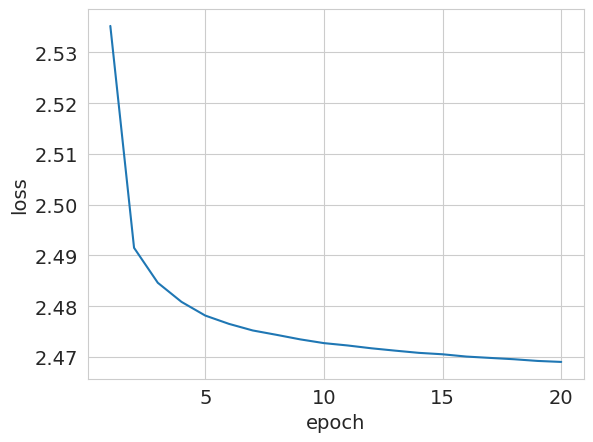

KeyboardInterrupt: 

In [20]:
losses = []
num_epochs = 25

for epoch in range(1, num_epochs + 1):
    print(epoch)
    running_loss = 0.0
    model.train()
    for tokens, lengths in dataloader:
        optimizer.zero_grad()
        tokens = tokens[:, :lengths.max()].to(device)
        logits = model(tokens[:, :-1], lengths - 1)
        # logits: (B, L, V), tokens: (B, L) - need to transpose logits
        loss = criterion(logits.transpose(1, 2), tokens[:, 1:])
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * tokens.shape[0]

    losses += [running_loss / len(dataset)]

    if epoch % 10 == 0:
        plot_losses(losses)

In [21]:
# unconditional generation
[model.inference('') for _ in range(10)]

['Sheinza',
 'Hemashi',
 'Rokiel',
 'Zakran',
 'Fitgeree',
 'Bwinmed',
 'Panalov',
 'Agris',
 'Samanhle',
 'Gaddice']

In [25]:
# conditional generation from prefix
[model.inference('ma') for _ in range(10)]

['maliegala',
 'maya',
 'madaze',
 'marrx',
 'mayicen',
 'mahshn',
 'martyuju',
 'machika',
 'mayol',
 'malisha']

# 2. Image captioning

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [31]:
%%bash
kaggle datasets download -d hsankesara/flickr-image-dataset
unzip flickr-image-dataset.zip

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 8.16G/8.16G [00:53<00:00, 163MB/s]


In [27]:
import os
import pandas as pd
from PIL import Image

In [32]:
captions = pd.read_csv('flickr30k_images/results.csv', sep='\|\ ').dropna()
captions

<ipython-input-32-f688a851a982>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  captions = pd.read_csv('flickr30k_images/results.csv', sep='\|\ ').dropna()


,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their ...
1,1000092795.jpg,1,"Two young , White males are outside near many ..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .
...,...,...,...
158910,998845445.jpg,0,A man in shorts and a Hawaiian shirt leans ove...
158911,998845445.jpg,1,"A young man hanging over the side of a boat , ..."
158912,998845445.jpg,2,A man is leaning off of the side of a blue and...
158913,998845445.jpg,3,"A man riding a small boat in a harbor , with f..."


1: A little boy in a blue shirt with a pacifier playing with a bubble machine in front of a man running .
2: A young child with a hat on playing with a bubble machine .
3: A small boy with a blue shirt playing with a toy .
4: A young boy in a blue shirt plays with bubbles .
5: Toddler with a tan hat playing .


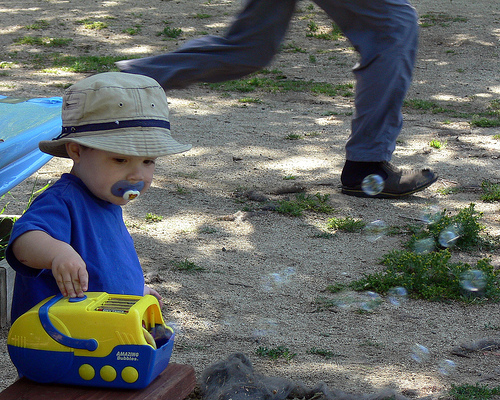

In [33]:
image_file = captions.image_name.sample(1).iloc[0]
for i, caption in enumerate(captions[captions.image_name == image_file].comment):
    print(f'{i + 1}:', caption)
Image.open(os.path.join('flickr30k_images/flickr30k_images', image_file))

In [34]:
image_ids = {k: i for i, k in enumerate(captions.image_name.unique())}
image_list = list(map(lambda x: x[0], sorted(image_ids.items(), key=lambda x: x[1])))
captions['image_id'] = captions.image_name.map(image_ids)

In [35]:
from torch.utils.data import Dataset, DataLoader

class ImagesDataset(Dataset):
    def __init__(self, root, image_list, transform=None):
        super().__init__()
        self.root = root
        self.image_list = image_list
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, item):
        image_path = os.path.join(self.root, self.image_list[item])
        image = Image.open(image_path).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)

        return image

In [36]:
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [37]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from torch import nn

cnn_model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1).eval().to(device)
cnn_model.classifier = nn.Identity()

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 107MB/s] 


In [38]:
import torchvision.transforms as T

transform = T.Compose([
    T.ToTensor(),
    T.Resize(256),
    T.CenterCrop(224),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ImagesDataset(root='flickr30k_images/flickr30k_images', image_list=image_list, transform=transform)
dataloader = DataLoader(dataset, num_workers=4, shuffle=False, batch_size=128)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [39]:
from tqdm.auto import tqdm

image_embeds = []

with torch.no_grad():
    for images in tqdm(dataloader):
        embeds = cnn_model(images.to(device))
        image_embeds += [embeds.cpu()]

display(image_embeds.shape)
image_embeds = torch.cat(image_embeds, dim=0)
image_embeds.shape

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/249 [00:00<?, ?it/s]

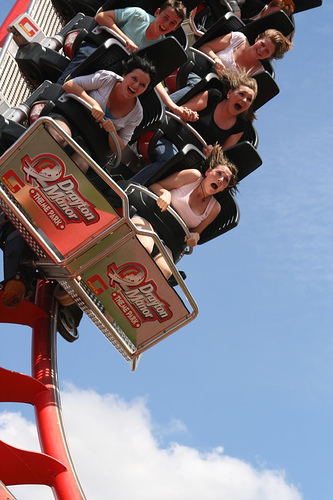

In [40]:
i = 626
image = Image.open(f'flickr30k_images/flickr30k_images/{image_list[i]}').convert('RGB')
image

In [41]:
captions[captions.image_id == 1001]

,image_name,comment_number,comment,image_id
5005,1315116409.jpg,0,A Drayton Manor Theme Park roller coaster is s...,1001
5006,1315116409.jpg,1,The Drayton Manor Theme Park roller coaster on...,1001
5007,1315116409.jpg,2,While everybody else is having fun on a roller...,1001
5008,1315116409.jpg,3,Several people are riding on a roller coaster ...,1001
5009,1315116409.jpg,4,Family of people right before they crash to th...,1001


In [42]:
image_embeds[i]

tensor([1.5271, 1.4365, 0.1388,  ..., 0.7424, 0.2805, 0.5695])

In [43]:
cnn_model(transform(image).to(device).unsqueeze(0))

tensor([[1.5271, 1.4365, 0.1388,  ..., 0.7424, 0.2805, 0.5695]],
       device='cuda:0', grad_fn=<ViewBackward0>)

In [44]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_embeds, test_embeds = \
    train_test_split(image_list, image_embeds, test_size=0.25, random_state=42)

train_embeds.shape, test_embeds.shape

(torch.Size([23837, 1280]), torch.Size([7946, 1280]))

In [45]:
import torchvision.transforms as T

transform = T.Compose([
    T.ToTensor(),
    T.Resize(256),
    T.CenterCrop(224),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ImagesDataset(root='flickr30k_images/flickr30k_images', image_list=image_list, transform=transform)
dataloader = DataLoader(dataset, num_workers=4, shuffle=False, batch_size=128)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [46]:
train_captions = captions[captions.image_name.isin(train_images)]
test_captions = captions[captions.image_name.isin(test_images)]

train_captions.shape, test_captions.shape

((119184, 4), (39730, 4))

In [47]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer("basic_english", language="en")
train_captions['tokens'] = train_captions.comment.apply(tokenizer)
test_captions['tokens'] = test_captions.comment.apply(tokenizer)

specials = ['<pad>', '<bos>', '<eos>', '<unk>']
vocab = build_vocab_from_iterator(train_captions.tokens, specials=specials, min_freq=5)
itos = vocab.get_itos()

PAD_IDX, BOS_IDX, EOS_IDX, UNK_IDX = vocab['<pad>'], vocab['<bos>'], vocab['<eos>'], vocab['<unk>']
vocab.set_default_index(UNK_IDX)
VOCAB_SIZE = len(vocab)
VOCAB_SIZE

<ipython-input-47-ace455c4efb3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_captions['tokens'] = train_captions.comment.apply(tokenizer)
<ipython-input-47-ace455c4efb3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_captions['tokens'] = test_captions.comment.apply(tokenizer)


6829

Train max length: 79


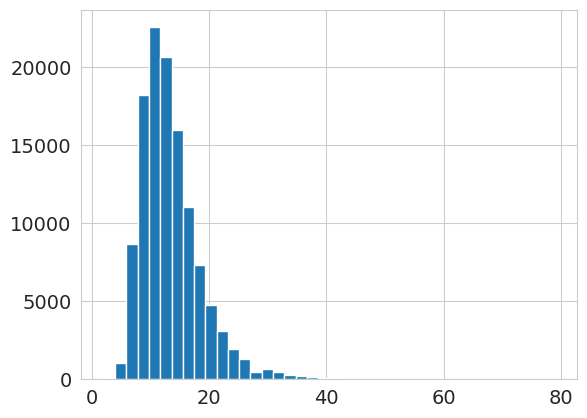

In [48]:
print('Train max length:', train_captions.tokens.apply(len).max())
plt.hist(train_captions.tokens.apply(len), bins=40)
MAX_LENGTH = 40
plt.show()

In [49]:
train_captions

,image_name,comment_number,comment,image_id,tokens
0,1000092795.jpg,0,Two young guys with shaggy hair look at their ...,0,"[two, young, guys, with, shaggy, hair, look, a..."
1,1000092795.jpg,1,"Two young , White males are outside near many ...",0,"[two, young, ,, white, males, are, outside, ne..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .,0,"[two, men, in, green, shirts, are, standing, i..."
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .,0,"[a, man, in, a, blue, shirt, standing, in, a, ..."
4,1000092795.jpg,4,Two friends enjoy time spent together .,0,"[two, friends, enjoy, time, spent, together, .]"
...,...,...,...,...,...
158910,998845445.jpg,0,A man in shorts and a Hawaiian shirt leans ove...,31782,"[a, man, in, shorts, and, a, hawaiian, shirt, ..."
158911,998845445.jpg,1,"A young man hanging over the side of a boat , ...",31782,"[a, young, man, hanging, over, the, side, of, ..."
158912,998845445.jpg,2,A man is leaning off of the side of a blue and...,31782,"[a, man, is, leaning, off, of, the, side, of, ..."
158913,998845445.jpg,3,"A man riding a small boat in a harbor , with f...",31782,"[a, man, riding, a, small, boat, in, a, harbor..."


In [50]:
class CaptionsDataset(Dataset):
    def __init__(self, tokens, embeds):
        super().__init__()
        self.tokens = tokens
        self.embeds = embeds

    def __len__(self):
        return len(self.tokens)

    def tokens_to_idx(self, tokens):
        return [vocab[token] for token in tokens]

    def idx_to_tokens(self, idx):
        return [itos[index] for index in idx]

    def encode(self, tokens):
        tokens = ['<bos>'] + tokens + ['<eos>']
        return self.tokens_to_idx(tokens)

    def decode(self, idx):
        tokens = self.idx_to_tokens(idx)
        return ' '.join(token for token in tokens if token not in specials)

    def __getitem__(self, item):
        tokens = self.tokens.iloc[item].tokens
        encoded = self.encode(tokens)[:MAX_LENGTH + 2]
        padded = torch.full((MAX_LENGTH + 2, ), PAD_IDX, dtype=torch.int64)
        padded[:len(encoded)] = torch.tensor(encoded)

        image_id = self.tokens.iloc[item].image_id
        return padded, len(encoded), self.embeds[image_id]

In [51]:
train_set = CaptionsDataset(train_captions, image_embeds)
test_set = CaptionsDataset(test_captions, image_embeds)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)
embeds_loader = DataLoader(test_embeds, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [52]:
captions_list = []

for image in tqdm(test_images):
    data = test_captions[test_captions.image_name == image]
    captions_list += [data.comment.str.lower().tolist()]

  0%|          | 0/7946 [00:00<?, ?it/s]

In [53]:
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.distributions.categorical import Categorical
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights


class CaptionRNN(nn.Module):
    def __init__(self, image_embed_dim, embed_dim=256, hidden_dim=256, lstm_layers=1, dropout=0.1):
        super().__init__()
        self.lstm_layers = lstm_layers
        self.hidden_dim = hidden_dim

        self.image_embed_to_h0 = nn.Sequential(
            nn.Linear(image_embed_dim, lstm_layers * hidden_dim),
            nn.LeakyReLU(0.1),
        )
        self.image_embed_to_c0 = nn.Sequential(
            nn.Linear(image_embed_dim, lstm_layers * hidden_dim),
            nn.LeakyReLU(0.1),
        )

        self.embedding = nn.Embedding(num_embeddings=VOCAB_SIZE, embedding_dim=embed_dim,
                                      padding_idx=PAD_IDX)
        self.lstm = nn.LSTM(input_size=embed_dim, hidden_size=hidden_dim,
                            num_layers=lstm_layers, batch_first=True)
        self.linear = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, VOCAB_SIZE)
        )

    def forward(self, tokens, lengths, image_embeds):
        '''
        B - batch size
        M - lstm layers
        L - sequence length
        I - image embedding dim
        E - embedding dim
        H - hidden dim
        V - vocab size
        '''
        # image_embeds: (B, I)
        B = image_embeds.shape[0]
        h0 = self.image_embed_to_h0(image_embeds).reshape(B, self.lstm_layers, self.hidden_dim).transpose(0, 1)
        c0 = self.image_embed_to_c0(image_embeds).reshape(B, self.lstm_layers, self.hidden_dim).transpose(0, 1)
        # h0, co: (M, B, H)

        # tokens: (B, L)
        embeds = self.embedding(tokens)
        # embeds: (B, L, E) in padded form

        packed_embeds = pack_padded_sequence(embeds, lengths, batch_first=True, enforce_sorted=False)
        outputs, (h, c) = self.lstm(packed_embeds, (h0, c0))
        # output: (B, L, H) in packed form, (h, c): (M, B, H)
        outputs, lengths = pad_packed_sequence(outputs, batch_first=True)
        logits = self.linear(outputs)
        # logits: (B, L, V)
        return logits

    @torch.no_grad()
    def inference(self, image_embeds):
        self.eval()
        # generate lstm input
        B = image_embeds.shape[0]
        h = self.image_embed_to_h0(image_embeds).reshape(B, self.lstm_layers, self.hidden_dim).transpose(0, 1)
        c = self.image_embed_to_c0(image_embeds).reshape(B, self.lstm_layers, self.hidden_dim).transpose(0, 1)
        h, c = h.contiguous(), c.contiguous()

        # init tokens with <bos>
        tokens = torch.full((B, 1), BOS_IDX, device=image_embeds.device)
        new_tokens = tokens

        # 2 stopping conditions: reaching max len or getting <eos> token
        while tokens.shape[1] < MAX_LENGTH:
            if ((tokens == EOS_IDX).sum(1) > 0).all():
                break

            # process newly obtained token
            embeds = self.embedding(new_tokens)
            output, (h, c) = self.lstm(embeds, (h, c))
            logits = self.linear(output)

            # get new tokens from logits
            new_tokens = logits.argmax(dim=-1)
            tokens = torch.cat([tokens, new_tokens], dim=1)

        return tokens

In [54]:
# testing
model = CaptionRNN(image_embeds.shape[1])

for tokens, lengths, embeds in train_loader:
    break

tokens = tokens[:, :lengths.max()]
logits = model(tokens, lengths, embeds)
assert logits.shape == (tokens.shape[0], tokens.shape[1], VOCAB_SIZE)

tokens = model.inference(embeds)
train_set.decode(tokens[0])

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


'identifying benches charging cabs reflection boarding hose oh bulls daycare arguing few waling stomach squirts exercise luggage foreign peace literature led organized gymnasts torn punk calf starring street spring similarly speech spiderman squirts stool procession guitarists examined complex remote'

In [55]:
from IPython.display import clear_output
from tqdm.notebook import tqdm
import numpy as np


BLEU_FREQ = 5


def plot_losses(train_losses, test_losses, test_blues):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train', color='deepskyblue', linewidth=2)
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test', color='springgreen', linewidth=2)
    axs[0].set_ylabel('loss')

    axs[1].plot(BLEU_FREQ * np.arange(1, len(test_blues) + 1), test_blues, label='test',
                color='springgreen', linewidth=2)
    axs[1].set_ylabel('BLEU')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [56]:
!pip install torchmetrics
from torchmetrics import BLEUScore


def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss = 0.0
    model.train()
    for tokens, lengths, embeds in tqdm(train_loader, desc=tqdm_desc):
        embeds = embeds.to(device)
        tokens = tokens[:, :lengths.max()].to(device)

        optimizer.zero_grad()
        logits = model(tokens[:, :-1], lengths - 1, embeds)
        loss = criterion(logits.transpose(1, 2), tokens[:, 1:])
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * embeds.shape[0]

    train_loss /= len(train_loader.dataset)
    return train_loss


@torch.no_grad()
def validation_epoch(model, criterion, valid_loader, tqdm_desc):
    valid_loss = 0.0
    model.eval()
    for tokens, lengths, embeds in tqdm(valid_loader, desc=tqdm_desc):
        embeds = embeds.to(device)
        tokens = tokens[:, :lengths.max()].to(device)

        logits = model(tokens[:, :-1], lengths - 1, embeds)
        loss = criterion(logits.transpose(1, 2), tokens[:, 1:])

        valid_loss += loss.item() * embeds.shape[0]

    valid_loss /= len(valid_loader.dataset)
    return valid_loss


def evaluate_bleu(model, embeds_loader, captions):
    bleu = BLEUScore()
    predictions = []
    model.eval()
    for embeds in tqdm(embeds_loader, desc='Evaluating BLEU'):
        tokens = model.inference(embeds.to(device)).cpu()
        for token_list in tokens:
            predictions += [train_set.decode(token_list)]

    return bleu(predictions, captions).item()


def train(model, optimizer, scheduler, criterion, train_loader, valid_loader,
          embeds_loader, captions_list, num_epochs):
    train_losses, valid_losses, valid_blues = [], [], []

    for epoch in range(1, num_epochs + 1):
        train_loss = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        valid_loss = validation_epoch(
            model, criterion, valid_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        if epoch % BLEU_FREQ == 0:
            valid_bleu = evaluate_bleu(model, embeds_loader, captions_list)
            valid_blues += [valid_bleu]

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        valid_losses += [valid_loss]
        plot_losses(train_losses, valid_losses, valid_blues)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 4.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [57]:
NUM_EPOCHS = 20

model = CaptionRNN(image_embeds.shape[1], dropout=0.3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = None
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

sum(param.numel() for param in model.parameters())

4685485

In [58]:
print(f'Random BLEU: {evaluate_bleu(model, embeds_loader, captions_list):.4f}')

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `BLEUScore` from `torchmetrics` was deprecated and will be removed in 2.0. Import `BLEUScore` from `torchmetrics.text` instead.
  _future_warning(


Evaluating BLEU:   0%|          | 0/63 [00:00<?, ?it/s]

Random BLEU: 0.0000


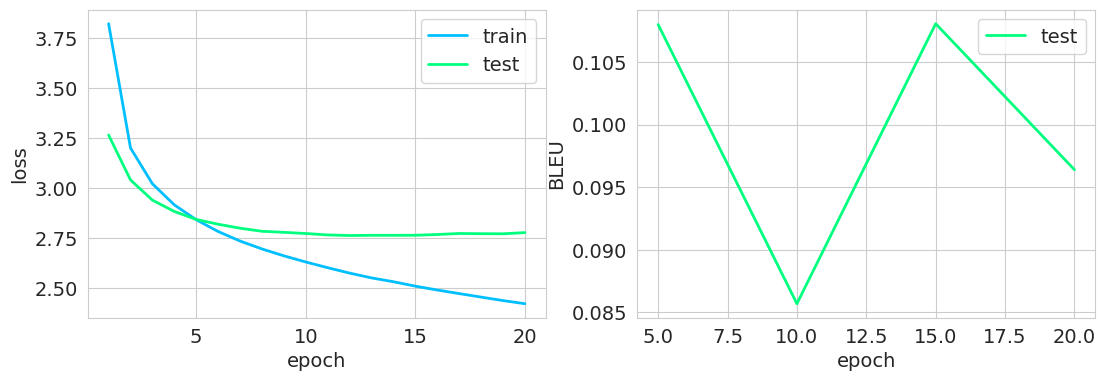

In [59]:
train(model, optimizer, scheduler, criterion, train_loader, test_loader,
      embeds_loader, captions_list, NUM_EPOCHS)

In [60]:
def caption_random_test_image():
    index = np.random.randint(len(test_images))
    image_file = test_images[index]
    tokens = model.inference(test_embeds[index].unsqueeze(0).to(device)).cpu().squeeze()
    prediction = train_set.decode(tokens)
    print('Prediction:', prediction)

    for i, caption in enumerate(captions[captions.image_name == image_file].comment):
        print(f'GT caption #{i + 1}:', caption)

    return Image.open(os.path.join('flickr30k_images/flickr30k_images', image_file)).convert('RGB')

Prediction: a dog is swimming in the water .
GT caption #1: A brown dog wearing a collar is running through some water .
GT caption #2: A brown dog is running in the water by the beach .
GT caption #3: A dog running through the water .
GT caption #4: A brown dog jumps in the ocean .
GT caption #5: A brown dog runs down a beach .


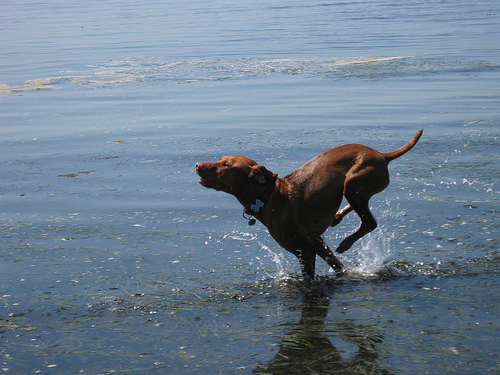

In [61]:
caption_random_test_image()